In [1]:
import time
from coffea import hist, nanoevents, util
import coffea.processor as processor
import awkward as ak
import numpy as np
import glob as glob
import re
import itertools
# import vector as vec
from coffea.nanoevents.methods import vector, candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema
from coffea.lumi_tools import LumiMask
# for applying JECs
from coffea.lookup_tools import extractor
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory
from coffea.jetmet_tools import JetResolution, JetResolutionScaleFactor
# from jmeCorrections import JetMetCorrections
import json


import coffea.processor as processor
from coffea import hist
from coffea.analysis_tools import PackedSelection, Weights
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory
from coffea.nanoevents.methods import nanoaod

# NanoAODSchema.warn_missing_crossrefs = False

import pickle
# np.errstate(invalid='ignore', divide='ignore')

import os



import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
from coffea.util import load, save

hists = load('/cms/scratch/sdogra/mtop/rishabh/decaf/analysis/hists/UL_had_ttag_cutflow_2018_New_v6_onetight_m_e.scaled') 

#hists = load('/cms/scratch/sdogra/mtop/rishabh/decaf/analysis/hists/UL_had_ttag_cutflow_2018_New_v6_gen.scaled')


data_hists = hists['data']
bkg_hists = hists['bkg']
sig_hists = hists['sig']

In [3]:
bkg_hists

{'template': <Hist (process,region,systematic,recoil) instance at 0x7f76844d0f98>,
 'ele_phi': <Hist (process,region,ele_phi) instance at 0x7f75b1b194a8>,
 'sumw': <Hist (process,sumw) instance at 0x7f75b1b20cf8>,
 'j1pt': <Hist (process,region,j1pt) instance at 0x7f75b1b26d30>,
 'metphi': <Hist (process,region,metphi) instance at 0x7f75b1b33630>,
 'ndflvM': <Hist (process,region,ndflvM) instance at 0x7f75b1b3eeb8>,
 'dr_mu_lj': <Hist (process,region,dr_mu_lj) instance at 0x7f75b1b4e710>,
 'ele_pT': <Hist (process,region,ele_pT) instance at 0x7f75b1b58f28>,
 'mu_eta': <Hist (process,region,mu_eta) instance at 0x7f75b1ae47b8>,
 'TvsQCD': <Hist (process,region,TvsQCD) instance at 0x7f75b1af7048>,
 'j1phi': <Hist (process,region,j1phi) instance at 0x7f75b1b01898>,
 'nfatjets': <Hist (process,region,nfatjets) instance at 0x7f75b1b150f0>,
 'recoil': <Hist (process,region,recoil) instance at 0x7f75b1a9c908>,
 'cutflow': <Hist (process,region,cut) instance at 0x7f75b1aad208>,
 'ndflvL': <Hist

In [11]:
#data_hists[vari].integrate('region', region).values()
data_hists[vari].integrate('process').integrate('region',region).sum(vari).values()

{(): 216999848.0}

In [12]:
cut_bin = None
exp = 0
vari = 'fj1pt'
region = 'tmcr'
print('======= ',region, '=======')
print('variable ', vari)
print('=====================')
for p in bkg_hists[vari].identifiers('process'):
    #print(p)
    yld_array = bkg_hists[vari].integrate('region',region).integrate('process', p).sum().values(overflow='all')
    if () in yld_array:
        #yld = np.cumsum(yld_array[()])[nbins-1]
        yld = yld_array[()].sum()
        if cut_bin!=None: yld = yld - np.cumsum(yld_array[()])[cut_bin]
        #if cut_bin!=None: yld = np.cumsum(yld_array[()])[cut_bin]
        exp += yld
        print(p, '%.1f' % yld)
#print(bkg_hists[vari].identifiers('process'))
bkg_hists[vari].integrate('region',region).integrate('process').sum('fj1pt').values()[()]

=======  tmcr =======
variable  fj1pt
DY 6543244.5
WW 545986.4
WZ 353326.9
ZZ 84837.1
ST 3213088.5
TT 22501415.6
WJets 47985182.8
ZJets 1611703.9
QCD 52897940244.2


52980606832.10581

MET


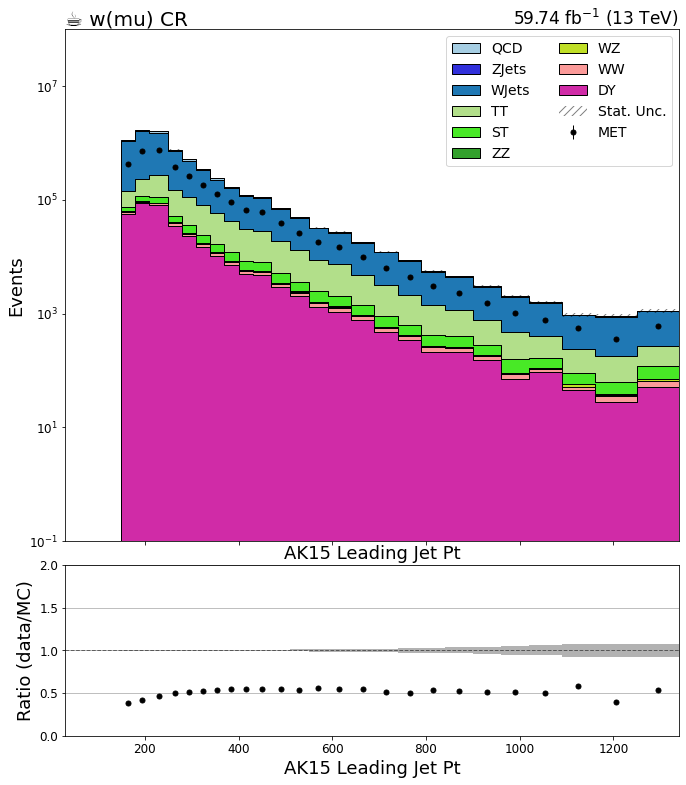

In [17]:
from cycler import cycler
from coffea.hist import plot


vari = 'fj1pt'
#vari = 'recoil'
region = 'wmcr'
if 'e' in region:
    data = 'EGamma'
    if 't' in region:
        R = 'tt(e) CR'
    if 'w' in region:
        R = 'w(e) CR'
else:
    data = 'MET'
    if 't' in region:
        R = 'tt(mu) CR'
    if 'w' in region:
        R = 'w(mu) CR'
#data = 'EGamma' 
#data = 'MET' 
#data = 'MET'
print(data)

plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
colors = ['#a6cee3', '#3130db', '#1f78b4', '#b2df8a', '#48e926', '#33a02c', '#c0df26',
          '#fb9a99', '#d02ba7', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#c64bc4',
          '#6a3d9a', '#a9ce26', '#ffff99', '#b15928', '#edcc43']
fig, (ax, rax) = plt.subplots(2, 1, figsize=(11,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)
ax.set_prop_cycle(cycler(color=colors))

plot.plot1d(data_hists[vari].integrate('region', region),#[data[year][str(j)]],
            overlay="process",
            ax=ax,
            overflow='over',
            clear=False,
            error_opts=data_err_opts
           )

plot.plot1d(bkg_hists[vari].integrate('region', region),
            overlay="process",
            ax=ax,
            overflow='over',
            clear=False,
            stack=True,
            fill_opts=fill_opts,
            error_opts=error_opts
           )

plot.plotratio(data_hists[vari].integrate('region', region).integrate('process', data),
               bkg_hists[vari].integrate('region', region).sum('process'),
               ax=rax,
               overflow='over',
               error_opts=data_err_opts,
               denom_fill_opts={},
               guide_opts={},
               unc='num'
              )

rax.set_ylabel('Ratio (data/MC)')
rax.set_ylim(0.0,2.0)
rax.grid(axis='y')

ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle':'--', 'linewidth': 5}
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim(.1, 100000000)

#ax.set_xlim(0, 1500)

leg = ax.legend(ncol=2, loc='best')
coffee = plt.text(0., 1., u"☕ "+R, fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
#coffee = plt.text(0., 1., u"☕ "+R[str(j).split('_')[0]], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
lumi = plt.text(1., 1., r"59.74 fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

#plot_path = os.path.abspath('/cms/scratch/sdogra/mtop/rishabh/decaf/analysis/plots/fixed_tau_0612/')
#plot_name = 'UL_had_fixedtau_'+vari+'_'+region+'.png'
#print(os.path.join(plot_path, plot_name))
#fig.savefig(os.path.join(plot_path, plot_name))

/cms/scratch/sdogra/mtop/rishabh/decaf/analysis/plots/2022kpsfall/had_mtop_recoil_tmcr.png


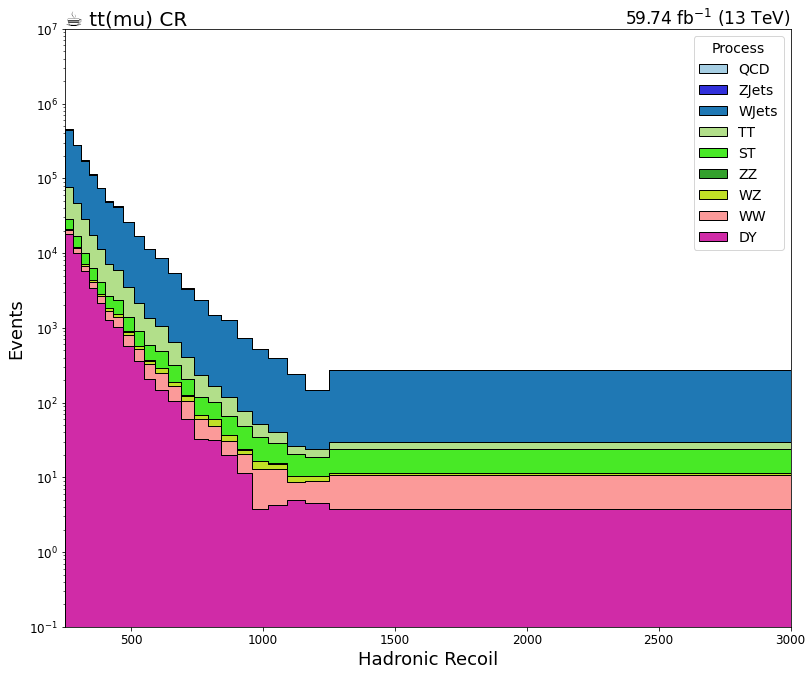

In [11]:
###################
## Wighout DATA
###################
from coffea.hist import plot
from cycler import cycler

vari = 'recoil'
region = 'tmcr'

if 'e' in region:
    data = 'EGamma'
    if 't' in region:
        R = 'tt(e) CR'
    if 'w' in region:
        R = 'w(e) CR'
else:
    data = 'MET'
    if 't' in region:
        R = 'tt(mu) CR'
    if 'w' in region:
        R = 'w(mu) CR'

plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fig, ax = plt.subplots(figsize=(13,11))
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
colors = ['#a6cee3', '#3130db', '#1f78b4', '#b2df8a', '#48e926', '#33a02c', '#c0df26',
          '#fb9a99', '#d02ba7', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#c64bc4',
          '#6a3d9a', '#a9ce26', '#ffff99', '#b15928', '#edcc43']
ax.set_prop_cycle(cycler(color=colors))
#plot.plot1d(data_hists[vari].integrate('region',region),overlay="process", stack=True,clear=False, fill_opts=fill_opts, ax=ax)
#plot.plot1d(bkg_hists[vari].integrate('region',region).integrate('process','DY+HF'), stack=True,clear=False, fill_opts=fill_opts, ax=ax)
plot.plot1d(bkg_hists[vari].integrate('region',region), stack=True,clear=False, fill_opts=fill_opts, ax=ax)


#coffee = plt.text(0., 1., u"☕ TTbar(m) CR", fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
coffee = plt.text(0., 1., u"☕ "+R, fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle':'--', 'linewidth': 5}
ax.set_yscale('log')
ax.set_ylim(.1, 10000000)
#ax.set_xlim(0, 3000)
lumi = plt.text(1., 1., r"59.74 fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

plot_path = os.path.abspath('/cms/scratch/sdogra/mtop/rishabh/decaf/analysis/plots/2022kpsfall/')
plot_name = 'had_mtop_'+vari+'_'+region+'.png'
print(os.path.join(plot_path, plot_name))
fig.savefig(os.path.join(plot_path, plot_name))

<Hist (region,fj1pt) instance at 0x7f038526b438>


(0.0, 1300.0)

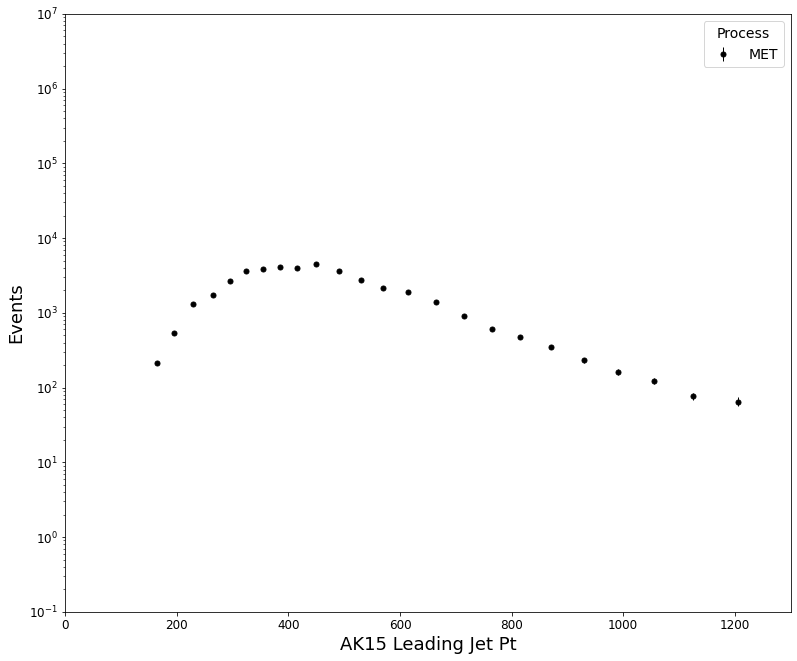

In [8]:
from coffea.hist import plot
vari = 'fj1pt'
plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fig, ax = plt.subplots(figsize=(13,11))

data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}

print(data_hists[vari].integrate('process'))
#plot.plot1d(bkg_hists[vari].integrate('region',region), stack=True)
plot.plot1d(data_hists[vari].integrate('region',region),overlay="process",error_opts=data_err_opts)
ax.set_yscale('log')
ax.set_ylim(.1, 10000000)
ax.set_xlim(0, 1300)

<AxesSubplot:xlabel='Hadronic Recoil', ylabel='Events'>

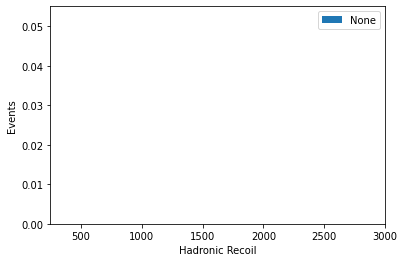

In [18]:
plot.plot1d(sig_hists[vari].integrate('process').integrate('region','sr'), stack=True)


In [63]:
data_hists[vari].identifiers('process')

[<StringBin (MET) instance at 0x7f7b6087b400>,
 <StringBin (EGamma) instance at 0x7f7b6087b518>]

In [64]:
data_hists[vari].integrate('region',region).values()

{('EGamma',): array([   0.,    0.,    0.,    0., 1427., 2954., 6198., 6530., 7829.,
        8294., 7627., 6752., 5607., 5830., 4318., 3156., 2375., 2008.,
        1345.,  916.,  613.,  488.,  375.,  266.,  187.,  115.,   98.,
          67.])}

<AxesSubplot:xlabel='AK15 Leading Jet Pt', ylabel='Events'>

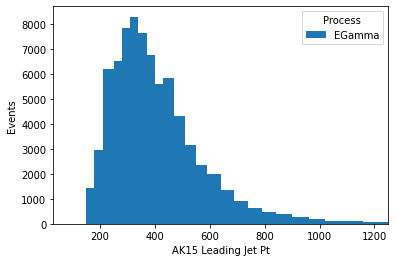

In [65]:
plot.plot1d(data_hists[vari].integrate('region',region), stack=True)


In [23]:
bkg_hists['sumw'].identifiers('process')#.identifiers('sumw')

[<StringBin (DY+HF) instance at 0x7f2a4100dbe0>,
 <StringBin (DY+LF) instance at 0x7f2a4100dc88>,
 <StringBin (WW) instance at 0x7f2a4100d978>,
 <StringBin (WZ) instance at 0x7f2a4100dcf8>,
 <StringBin (ZZ) instance at 0x7f2a4100d908>,
 <StringBin (ST) instance at 0x7f296f940358>,
 <StringBin (TT) instance at 0x7f296f8d7da0>,
 <StringBin (W+HF) instance at 0x7f296f8d7e10>,
 <StringBin (W+LF) instance at 0x7f296f8d7e48>,
 <StringBin (QCD) instance at 0x7f296f9032e8>]